In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import random
from typing import List, Tuple, Callable
import pandas as pd
from IPython.display import Markdown, display
import time
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation, cm
from dataclasses import dataclass, field

# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)

 # 1. Introduction to Particle Swarm Optimization

 Particle Swarm Optimization (PSO) is a population-based optimization technique inspired by the social behavior of birds flocking or fish schooling. Developed by Kennedy and Eberhart in 1995, PSO has become a popular algorithm for solving complex optimization problems.

 ## Key Concepts:

- **Particles**: Each solution candidate is represented as a particle in the search space
 - **Swarm Intelligence**: Particles cooperate and share information to find optimal solutions
 - **Personal Best**: Each particle remembers its best position
 - **Global Best**: The best position found by any particle in the swarm
 - **Velocity & Position Updates**: Particles move through the search space by updating their velocity and position

 ## Advantages of PSO:

 - Simple to implement
 - Few parameters to adjust
 - Efficient for global optimization
 - Works well in high-dimensional spaces
 - No gradient information required
 - Handles non-linear, non-convex optimization problems

# 2. PSO Algorithm Implementation


 ## 2.1 Base Configuration Class


In [ ]:
@dataclass
class AlgConfig:
    """Base configuration class for optimization algorithms"""

    def __post_init__(self) -> None:
        """Validate configuration parameters"""
        pass


## 2.2 PSO Configuration Class


In [ ]:
@dataclass
class PSOConfig(AlgConfig):
    """Configuration for the PSO algorithm"""
    objective_function: Callable[[List[float]], float]
    bounds: List[tuple[float, float]]
    n_dimensions: int = None
    n_particles: int = 30
    iterations: int = 100
    w: float = 0.5    # Inertia weight
    c1: float = 2.0   # Cognitive coefficient (personal best)
    c2: float = 2.0   # Social coefficient (global best)


    def __post_init__(self) -> None:
        """Initialize n_dimensions if not provided"""
        super().__post_init__()
        if self.n_dimensions is None:
            self.n_dimensions = len(self.bounds)

## 2.3 Particle Class


In [ ]:
class Particle:
    """
    Particle in the PSO algorithm.

    Each particle has a position, velocity, and memory of its best position.
    """
    def __init__(self, bounds: List[Tuple[float, float]], n_dimensions: int):
        """Initialize a particle with random position and velocity"""
        # Initialize position randomly within bounds
        self.position = [random.uniform(bounds[i][0], bounds[i][1]) for i in range(n_dimensions)]

        # Initialize velocity randomly
        self.velocity = [random.uniform(-1, 1) for _ in range(n_dimensions)]

        # Initialize personal best
        self.best_position = self.position.copy()
        self.best_fitness = float('inf')  # For minimization problems
        self.current_fitness = float('inf')

    def update_velocity(self, global_best_position: List[float], w: float, c1: float, c2: float) -> None:
        """Update the velocity of the particle"""
        for i in range(len(self.velocity)):
            # Inertia component
            inertia = w * self.velocity[i]

            # Cognitive component (personal best)
            r1 = random.random()
            cognitive = c1 * r1 * (self.best_position[i] - self.position[i])

            # Social component (global best)
            r2 = random.random()
            social = c2 * r2 * (global_best_position[i] - self.position[i])

            # Update velocity
            self.velocity[i] = inertia + cognitive + social

    def update_position(self, bounds: List[Tuple[float, float]]) -> None:
        """Update the position of the particle and handle boundary conditions"""
        for i in range(len(self.position)):
            # Update position
            self.position[i] += self.velocity[i]

            # Boundary handling - Reflect particles that go beyond bounds
            if self.position[i] < bounds[i][0]:
                self.position[i] = bounds[i][0]
                self.velocity[i] *= -0.5  # Bounce back with reduced velocity
            elif self.position[i] > bounds[i][1]:
                self.position[i] = bounds[i][1]
                self.velocity[i] *= -0.5  # Bounce back with reduced velocity

    def evaluate(self, objective_function: Callable[[List[float]], float]) -> float:
        """Evaluate the particle's current position and update best if improved"""
        self.current_fitness = objective_function(self.position)

        # Update personal best if current position is better
        if self.current_fitness < self.best_fitness:
            self.best_fitness = self.current_fitness
            self.best_position = self.position.copy()

        return self.current_fitness

## 2.4 Main PSO Implementation

In [ ]:
class ParticleSwarmOptimization:
    """
    Main PSO algorithm implementation.

    Manages the swarm of particles and the optimization process.
    """
    def __init__(self, config: PSOConfig):
        """Initialize the PSO algorithm with the given configuration"""
        self.config = config
        self.particles = []
        self.global_best_position = None
        self.global_best_fitness = float('inf')  # For minimization problems
        self.fitness_history = []
        self.avg_fitness_history = []
        self.position_history = []  # To track particle movements

        # Initialize particles
        for _ in range(config.n_particles):
            self.particles.append(Particle(config.bounds, config.n_dimensions))

    def optimize(self, store_positions=False) -> Tuple[List[float], float, List[float], List[float]]:
        """Run the optimization algorithm"""
        # Initial evaluation
        for particle in self.particles:
            fitness = particle.evaluate(self.config.objective_function)

            # Update global best if this particle is better
            if fitness < self.global_best_fitness:
                self.global_best_fitness = fitness
                self.global_best_position = particle.position.copy()

        # Store initial state
        if store_positions:
            positions = [p.position.copy() for p in self.particles]
            self.position_history.append(positions)

        self.fitness_history.append(self.global_best_fitness)

        # Main optimization loop
        for i in range(self.config.iterations):
            current_best_fitness = self.global_best_fitness
            total_fitness = 0

            # Update each particle
            for particle in self.particles:
                particle.update_velocity(
                    self.global_best_position,
                    self.config.w,
                    self.config.c1,
                    self.config.c2
                )
                particle.update_position(self.config.bounds)

                fitness = particle.evaluate(self.config.objective_function)
                total_fitness += fitness

                # Update global best if this particle is better
                if fitness < self.global_best_fitness:
                    self.global_best_fitness = fitness
                    self.global_best_position = particle.position.copy()

            # Store iteration history
            if store_positions:
                positions = [p.position.copy() for p in self.particles]
                self.position_history.append(positions)

            self.fitness_history.append(self.global_best_fitness)
            self.avg_fitness_history.append(total_fitness / len(self.particles))

        return (
            self.global_best_position,
            self.global_best_fitness,
            self.fitness_history,
            self.avg_fitness_history
        )

# 3. Visualizing the PSO Algorithm


## 3.1 Test Functions for Optimization

In [ ]:

def sphere_function(x: List[float]) -> float:
    """
    Sphere function: f(x) = sum(x_i^2)
    Global minimum at (0,...,0) with value 0
    """
    return sum(xi**2 for xi in x)

def rosenbrock_function(x: List[float]) -> float:
    """
    Rosenbrock function: f(x) = sum(100*(x_i+1 - x_i^2)^2 + (1-x_i)^2)
    Global minimum at (1,...,1) with value 0
    """
    return sum(100*(x[i+1] - x[i]**2)**2 + (1-x[i])**2 for i in range(len(x)-1))

def rastrigin_function(x: List[float]) -> float:
    """
    Rastrigin function: f(x) = 10*n + sum(x_i^2 - 10*cos(2*pi*x_i))
    Global minimum at (0,...,0) with value 0
    """
    n = len(x)
    return 10*n + sum(xi**2 - 10*np.cos(2*np.pi*xi) for xi in x)

def himmelblau_function(x: List[float]) -> float:
    """
    Himmelblau's function (2D): f(x,y) = (x^2 + y - 11)^2 + (x + y^2 - 7)^2
    Has four local minima with value 0
    """
    if len(x) != 2:
        raise ValueError("Himmelblau function requires exactly 2 dimensions")
    return (x[0]**2 + x[1] - 11)**2 + (x[0] + x[1]**2 - 7)**2

## 3.2 Visualization Functions

In [ ]:
def plot_2d_function(func, bounds, resolution=100, title="Function Surface"):
    """Plot a 2D function surface"""
    x = np.linspace(bounds[0][0], bounds[0][1], resolution)
    y = np.linspace(bounds[1][0], bounds[1][1], resolution)
    X, Y = np.meshgrid(x, y)
    Z = np.zeros_like(X)

    for i in range(resolution):
        for j in range(resolution):
            Z[i, j] = func([X[i, j], Y[i, j]])

    fig = plt.figure(figsize=(12, 5))

    # 3D Surface plot
    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    surface = ax1.plot_surface(X, Y, Z, cmap=cm.viridis, alpha=0.8)
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('f(X, Y)')
    ax1.set_title(f'{title} - 3D View')
    fig.colorbar(surface, ax=ax1, shrink=0.5, aspect=5)

    # Contour plot
    ax2 = fig.add_subplot(1, 2, 2)
    contour = ax2.contourf(X, Y, Z, 50, cmap=cm.viridis)
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_title(f'{title} - Contour View')
    fig.colorbar(contour, ax=ax2)

    plt.tight_layout()
    plt.show()

### Usage example


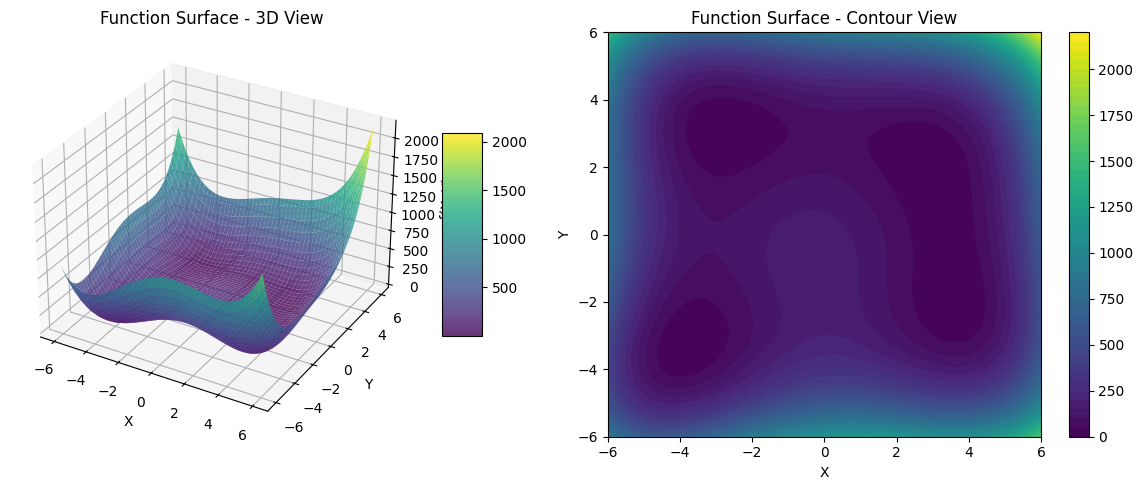

In [ ]:
plot_2d_function(himmelblau_function, [(-6, 6), (-6, 6)])


In [ ]:
def plot_convergence(fitness_history, avg_fitness_history=None, title="PSO Convergence"):
    """Plot the convergence of the PSO algorithm"""
    plt.figure(figsize=(10, 6))
    plt.plot(fitness_history, 'b-', linewidth=2, label='Global Best Fitness')
    if avg_fitness_history:
        plt.plot(avg_fitness_history, 'r--', linewidth=1, label='Average Swarm Fitness')
    plt.xlabel('Iteration')
    plt.ylabel('Fitness Value')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.yscale('log')  # Use log scale for better visualization
    plt.show()

In [ ]:

def visualize_pso_2d(func, bounds, position_history, global_best_pos, title="PSO Optimization"):
    """Visualize PSO particles movement in 2D space"""
    # Create function surface
    resolution = 100
    x = np.linspace(bounds[0][0], bounds[0][1], resolution)
    y = np.linspace(bounds[1][0], bounds[1][1], resolution)
    X, Y = np.meshgrid(x, y)
    Z = np.zeros_like(X)

    for i in range(resolution):
        for j in range(resolution):
            Z[i, j] = func([X[i, j], Y[i, j]])

    # Plot settings
    fig, ax = plt.subplots(figsize=(10, 8))
    contour = ax.contourf(X, Y, Z, 50, cmap=cm.viridis, alpha=0.8)
    fig.colorbar(contour, ax=ax)

    # Plot particle positions for each iteration
    colors = plt.cm.jet(np.linspace(0, 1, len(position_history)))

    for i, positions in enumerate(position_history):
        x_pos = [p[0] for p in positions]
        y_pos = [p[1] for p in positions]

        # Use smaller markers and decreasing alpha for earlier iterations
        alpha = 0.3 + 0.7 * (i / len(position_history))
        size = 10 + 40 * (i / len(position_history))

        # Only plot some iterations to avoid cluttering
        if i % max(1, len(position_history) // 10) == 0 or i == len(position_history) - 1:
            ax.scatter(x_pos, y_pos, color=colors[i], s=size, alpha=alpha,
                       edgecolors='k', linewidths=0.5, label=f'Iteration {i}')

    # Mark the global best position
    ax.scatter(global_best_pos[0], global_best_pos[1], color='red', s=200, marker='*',
               edgecolors='k', linewidths=1.5, label='Global Best')

    # Mark the true optimum if using a test function
    if func == sphere_function:
        ax.scatter(0, 0, color='white', s=200, marker='x', linewidths=2, label='True Optimum')
    elif func == himmelblau_function:
        # Himmelblau has four optima
        optima = [(3.0, 2.0), (-2.805118, 3.131312), (-3.779310, -3.283186), (3.584428, -1.848126)]
        for opt in optima:
            ax.scatter(opt[0], opt[1], color='white', s=100, marker='+', linewidths=2)
        ax.scatter([], [], color='white', s=100, marker='+', linewidths=2, label='True Optima')  # For legend

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title(title)

    # Show only a few iterations in the legend to avoid cluttering
    handles, labels = ax.get_legend_handles_labels()
    selected_indices = [i for i in range(len(labels)) if 'Iteration' not in labels[i] or
                        int(labels[i].split()[-1]) in [0, len(position_history)//2, len(position_history)-1]]
    ax.legend([handles[i] for i in selected_indices], [labels[i] for i in selected_indices],
              loc='upper right')

    plt.tight_layout()
    plt.show()

### usage example


In [ ]:

def demonstrate_pso_on_test_function(func_name, dimensions=2, n_particles=30, iterations=50):
    """Demonstrate PSO on a selected test function"""
    # Select function and bounds based on the name
    if func_name == "sphere":
        func = sphere_function
        bounds = [(-5.12, 5.12)] * dimensions
        title = "Sphere Function"
        true_optimum = [0] * dimensions
    elif func_name == "rosenbrock":
        func = rosenbrock_function
        bounds = [(-2.048, 2.048)] * dimensions
        title = "Rosenbrock Function"
        true_optimum = [1] * dimensions
    elif func_name == "rastrigin":
        func = rastrigin_function
        bounds = [(-5.12, 5.12)] * dimensions
        title = "Rastrigin Function"
        true_optimum = [0] * dimensions
    elif func_name == "himmelblau":
        if dimensions != 2:
            dimensions = 2
            print("Himmelblau function is strictly 2D. Setting dimensions to 2.")
        func = himmelblau_function
        bounds = [(-5, 5), (-5, 5)]
        title = "Himmelblau Function"
        true_optimum = "(3.0, 2.0), (-2.81, 3.13), (-3.78, -3.28), or (3.58, -1.85)"
    else:
        raise ValueError(f"Unknown function: {func_name}")

    # Display information
    display(Markdown(f"# Demonstrating PSO on {title}"))

    if dimensions == 2:
        display(Markdown("## Function Visualization"))
        plot_2d_function(func, bounds, title=title)

    # Configure and run PSO
    display(Markdown("## Running PSO"))

    config = PSOConfig(
        objective_function=func,
        bounds=bounds,
        n_dimensions=dimensions,
        n_particles=n_particles,
        iterations=iterations,
        w=0.7,  # Slightly higher inertia for exploration
        c1=1.5,
        c2=2.0   # Slightly higher social coefficient
    )

    pso = ParticleSwarmOptimization(config)

    start_time = time.time()
    best_pos, best_fitness, fitness_history, avg_fitness_history = pso.optimize(store_positions=dimensions==2)
    elapsed_time = time.time() - start_time

    # Display results
    display(Markdown("## Results"))
    display(Markdown(f"**Execution Time:** {elapsed_time:.4f} seconds"))
    display(Markdown(f"**Best Position Found:** {[round(x, 6) for x in best_pos]}"))
    display(Markdown(f"**Best Fitness Value:** {best_fitness:.8e}"))
    display(Markdown(f"**True Optimum Position:** {true_optimum}"))
    display(Markdown(f"**True Optimum Value:** 0"))

    # Calculate error (if applicable)
    if func_name != "himmelblau":  # Himmelblau has multiple optima
        error = np.sqrt(sum((best_pos[i] - true_optimum[i])**2 for i in range(dimensions)))
        display(Markdown(f"**Distance to True Optimum:** {error:.8f}"))

    # Plot convergence
    display(Markdown("## Convergence Plot"))
    plot_convergence(fitness_history, avg_fitness_history, title=f"PSO Convergence on {title}")

    # Visualize particle movement (2D only)
    if dimensions == 2 and hasattr(pso, 'position_history') and pso.position_history:
        display(Markdown("## Particle Movement Visualization"))
        visualize_pso_2d(func, bounds, pso.position_history, best_pos, title=f"PSO Optimization of {title}")


### Test on rastrigin function


# Demonstrating PSO on Sphere Function

## Function Visualization

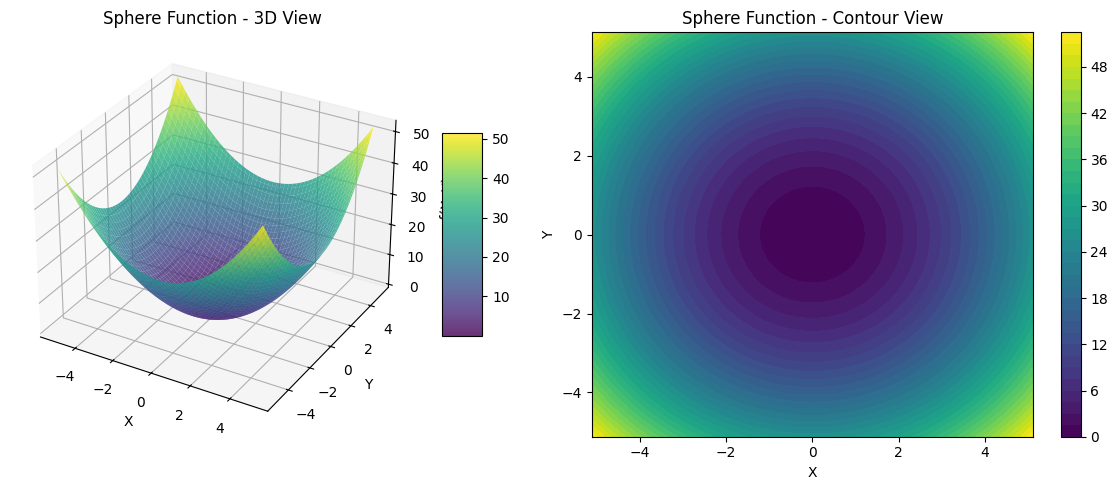

## Running PSO

## Results

**Execution Time:** 0.0408 seconds

**Best Position Found:** [-0.0, 0.0]

**Best Fitness Value:** 1.30889615e-29

**True Optimum Position:** [0, 0]

**True Optimum Value:** 0

**Distance to True Optimum:** 0.00000000

## Convergence Plot

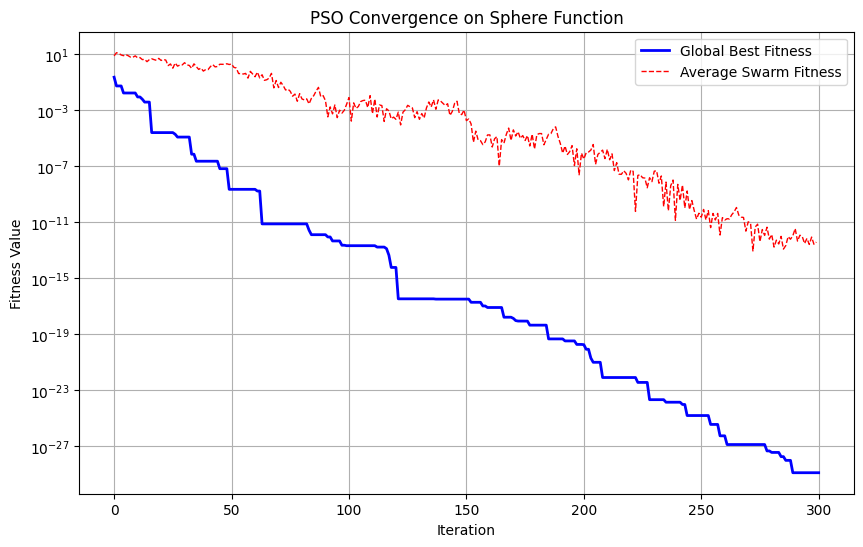

## Particle Movement Visualization

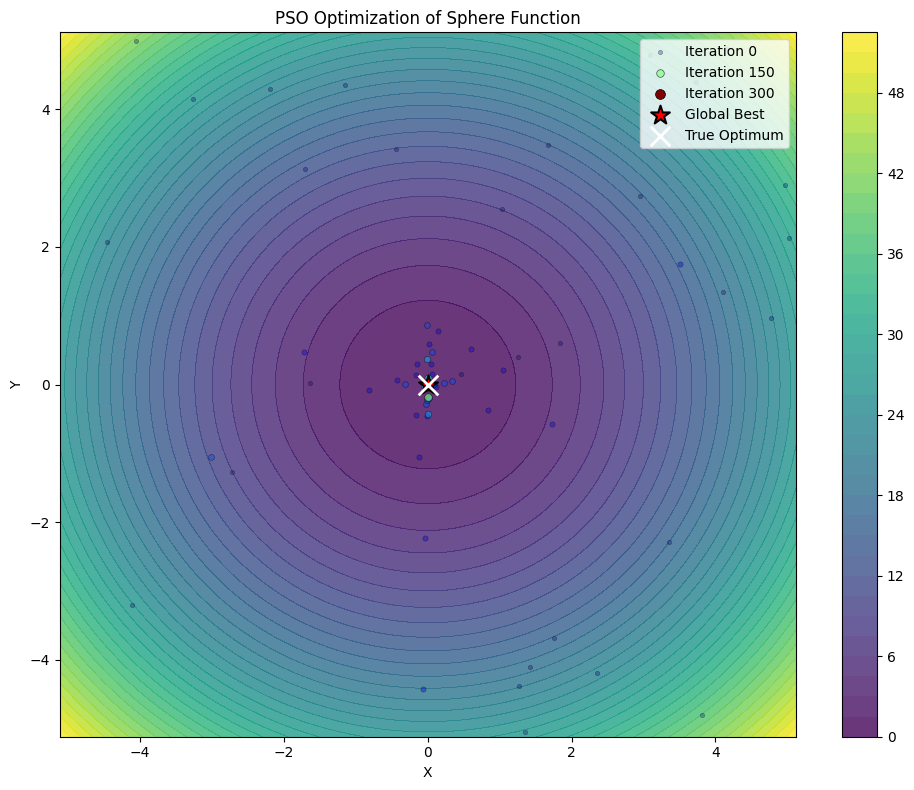

In [ ]:
demonstrate_pso_on_test_function("sphere", dimensions=2, n_particles=30, iterations=300)

# Demonstrating PSO on Rosenbrock Function

## Function Visualization

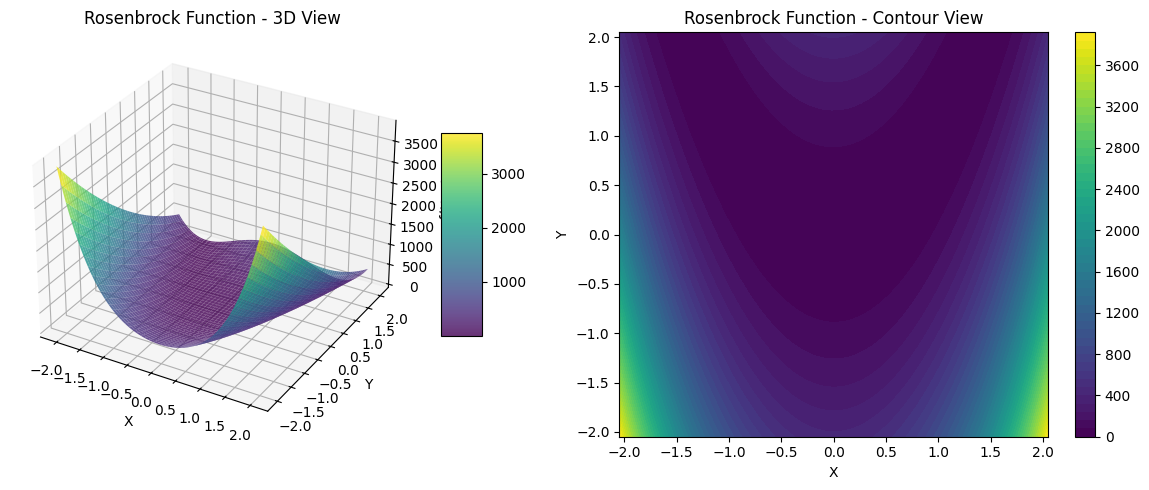

## Running PSO

## Results

**Execution Time:** 0.0151 seconds

**Best Position Found:** [0.996845, 0.993217]

**Best Fitness Value:** 3.32252051e-05

**True Optimum Position:** [1, 1]

**True Optimum Value:** 0

**Distance to True Optimum:** 0.00748102

## Convergence Plot

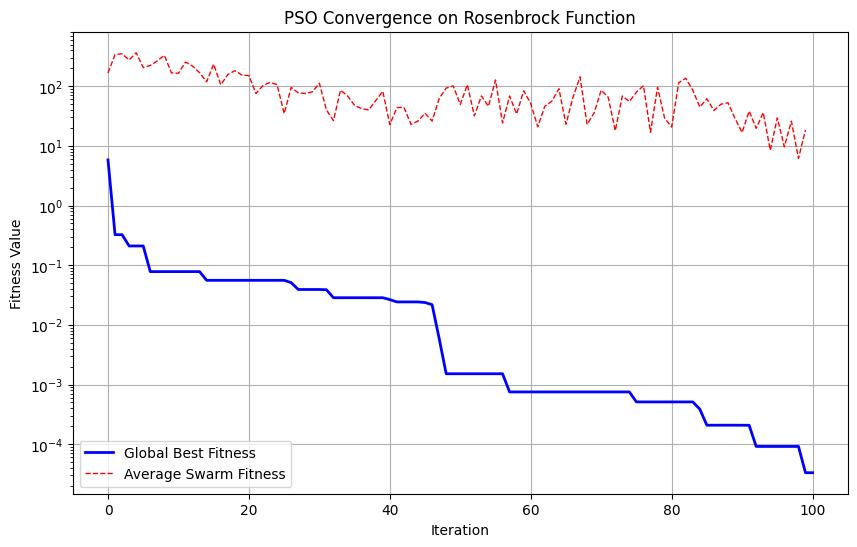

## Particle Movement Visualization

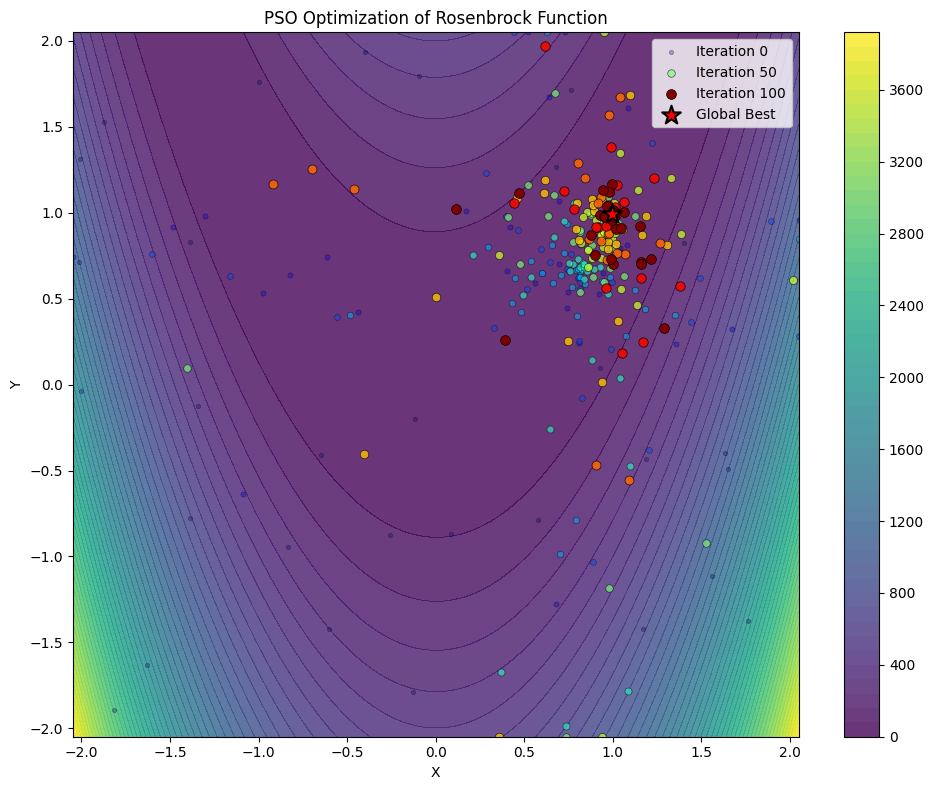

In [26]:
demonstrate_pso_on_test_function("rosenbrock", dimensions=2, n_particles=30, iterations=100)

# Demonstrating PSO on Rosenbrock Function

## Function Visualization

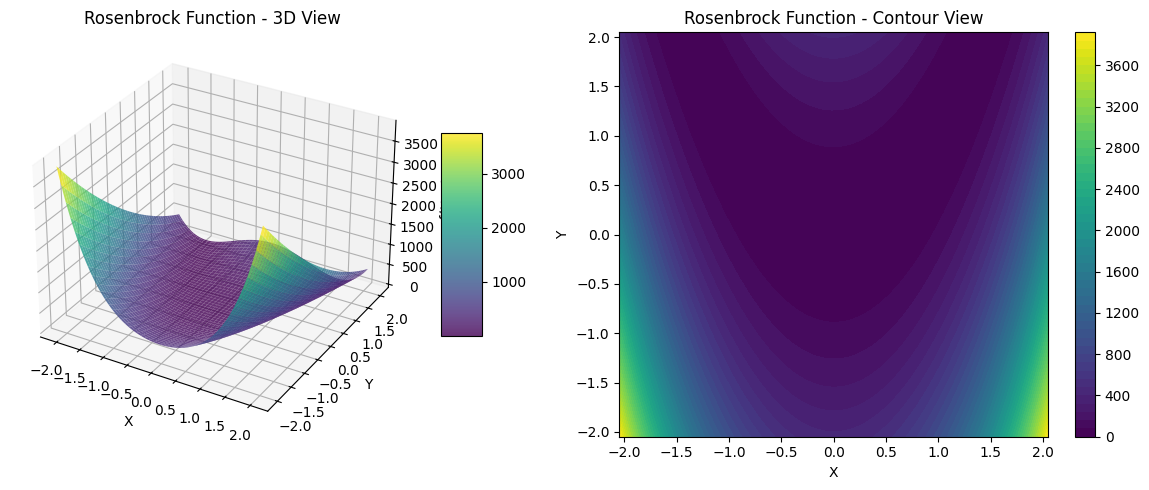

## Running PSO

## Results

**Execution Time:** 0.0562 seconds

**Best Position Found:** [1.000003, 1.000007]

**Best Fitness Value:** 6.43580776e-11

**True Optimum Position:** [1, 1]

**True Optimum Value:** 0

**Distance to True Optimum:** 0.00000712

## Convergence Plot

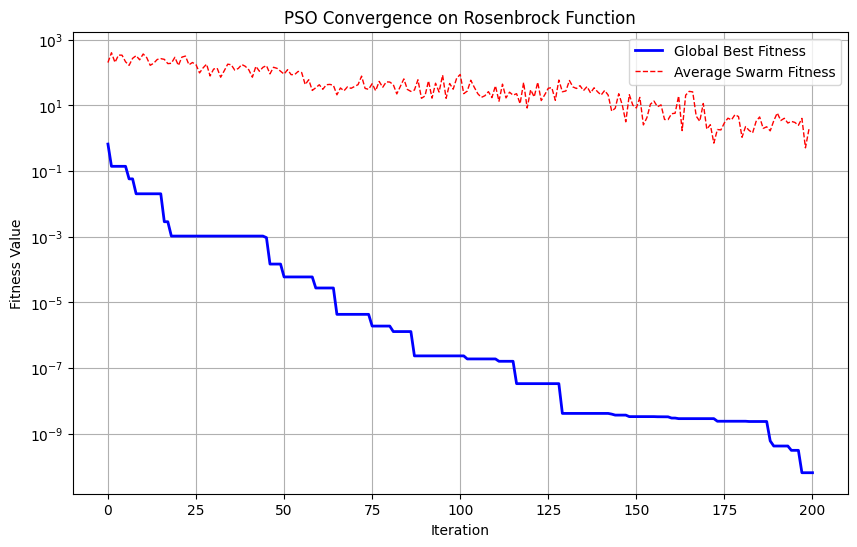

## Particle Movement Visualization

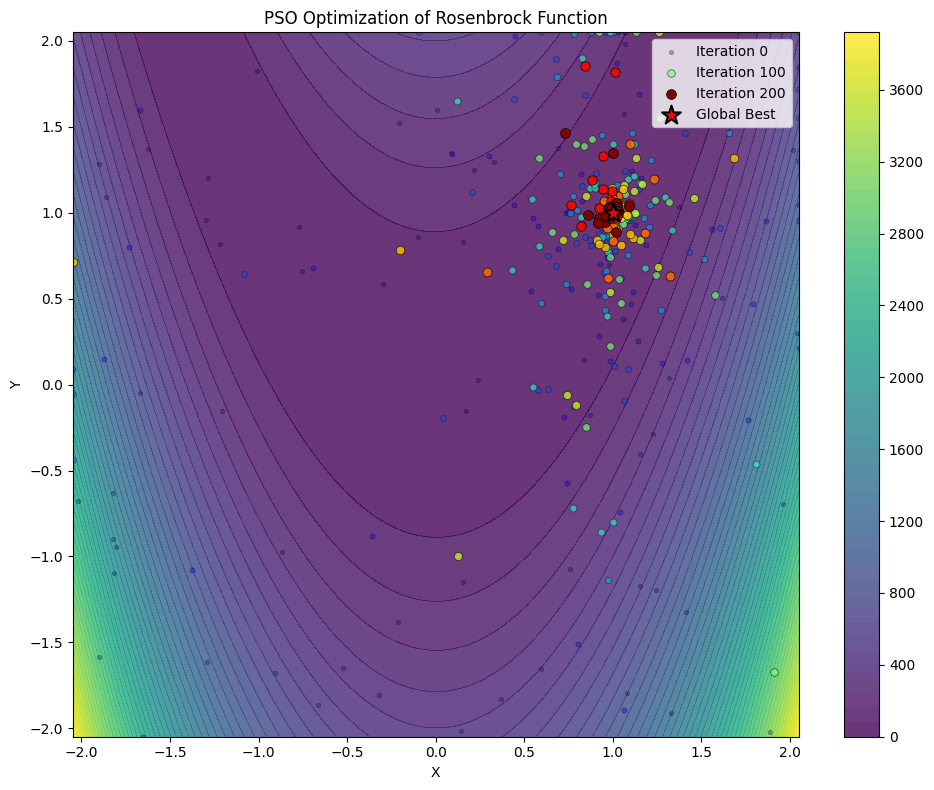

In [27]:
demonstrate_pso_on_test_function("rosenbrock", dimensions=2, n_particles=60, iterations=200)

# Demonstrating PSO on Rastrigin Function

## Function Visualization

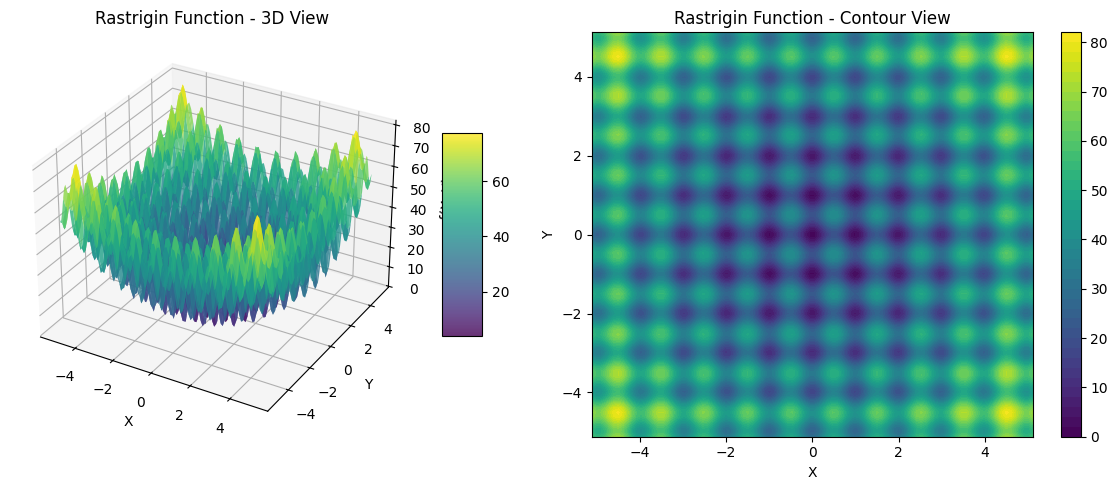

## Running PSO

## Results

**Execution Time:** 0.1475 seconds

**Best Position Found:** [-0.0, 0.0]

**Best Fitness Value:** 0.00000000e+00

**True Optimum Position:** [0, 0]

**True Optimum Value:** 0

**Distance to True Optimum:** 0.00000000

## Convergence Plot

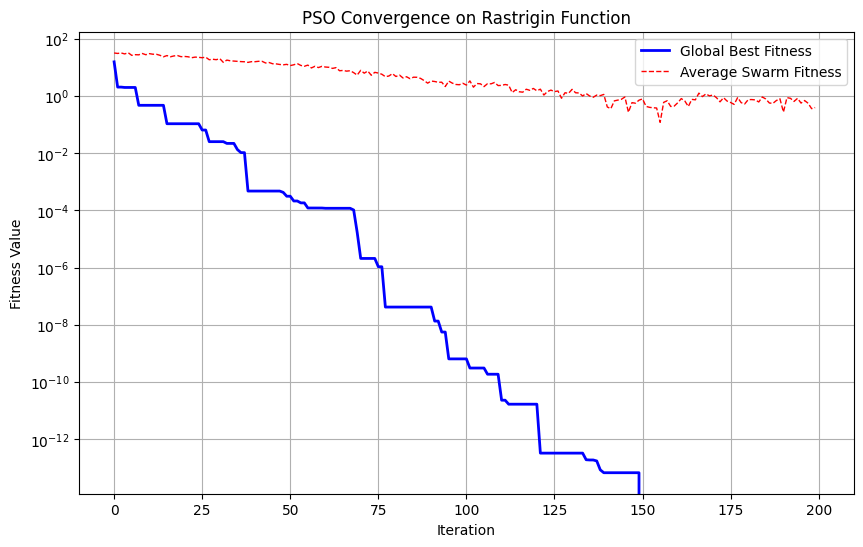

## Particle Movement Visualization

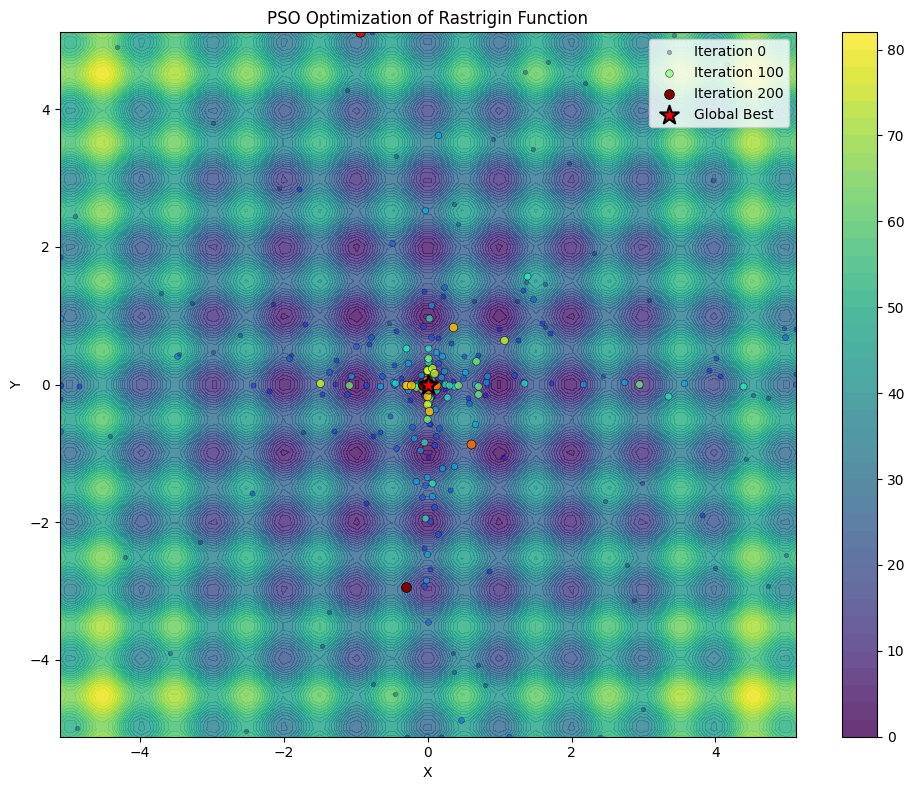

In [29]:
demonstrate_pso_on_test_function("rastrigin", dimensions=2, n_particles=60, iterations=200)

# Demonstrating PSO on Himmelblau Function

## Function Visualization

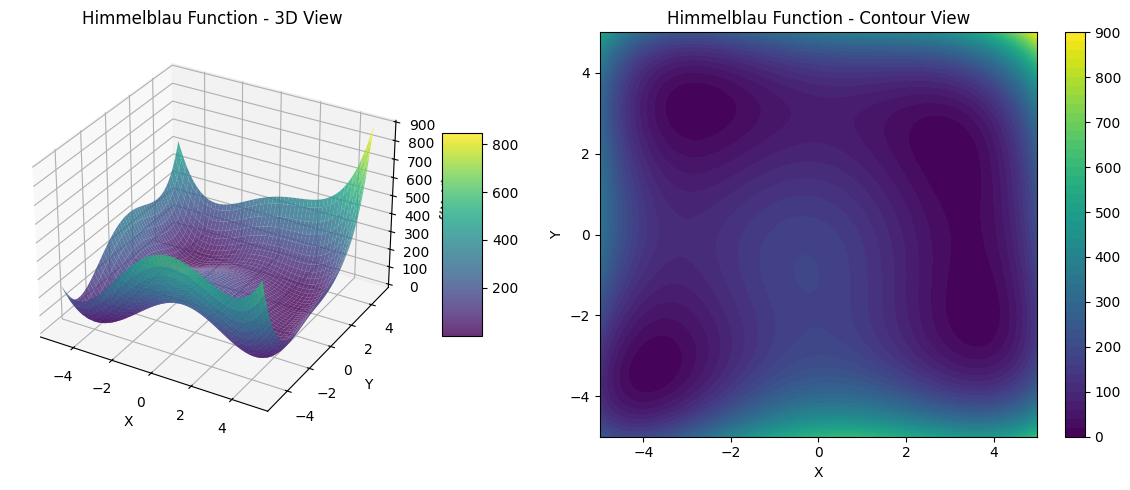

## Running PSO

## Results

**Execution Time:** 0.1648 seconds

**Best Position Found:** [3.584428, -1.848127]

**Best Fitness Value:** 1.57901591e-17

**True Optimum Position:** (3.0, 2.0), (-2.81, 3.13), (-3.78, -3.28), or (3.58, -1.85)

**True Optimum Value:** 0

## Convergence Plot

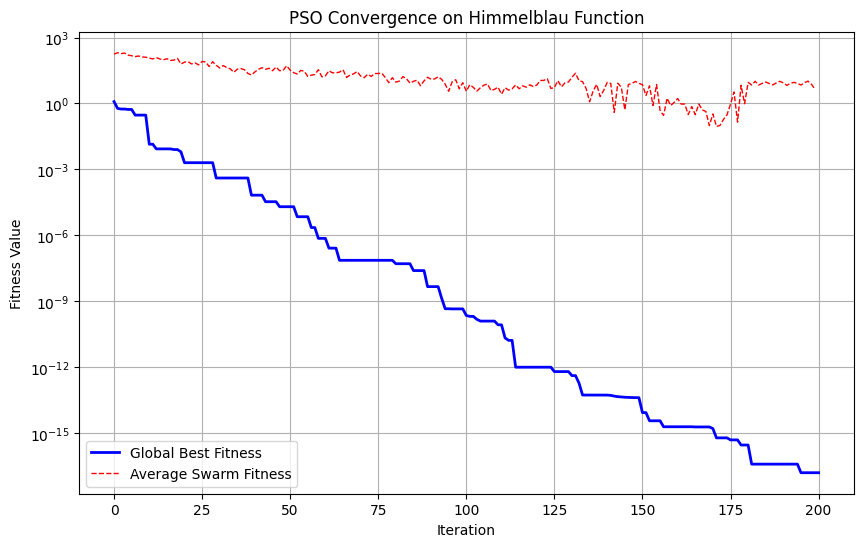

## Particle Movement Visualization

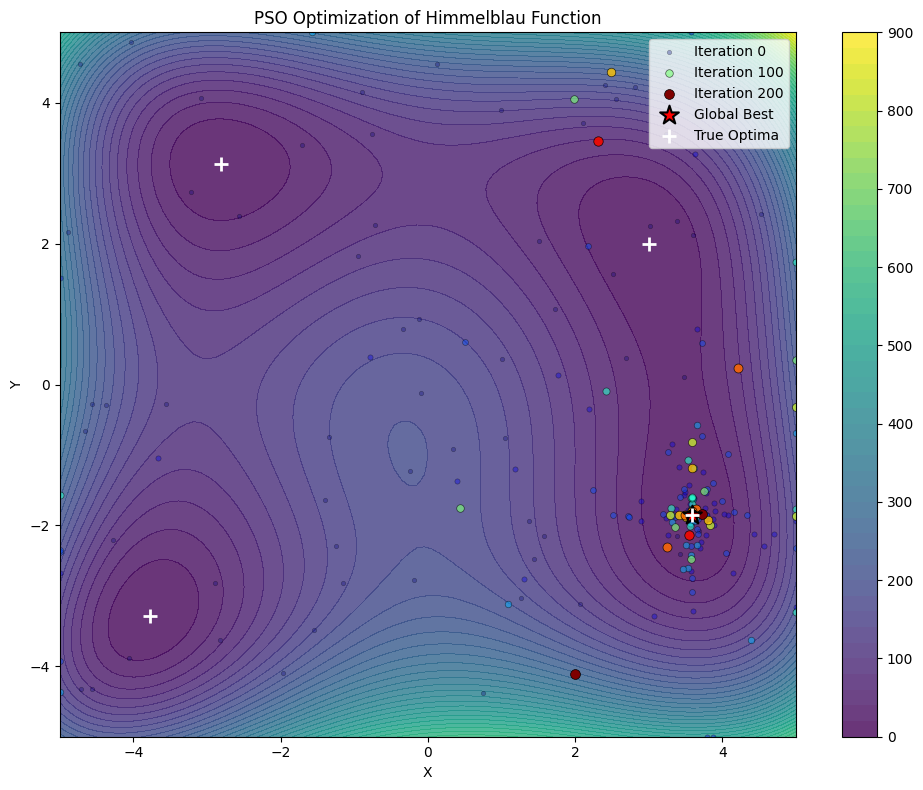

In [30]:
demonstrate_pso_on_test_function("himmelblau", dimensions=2, n_particles=60, iterations=200)